# ViT + GPT-2 Image captioning model

Installing the additinal Libraries required

In [1]:
%pip install -U accelerate
%pip install datasets
%pip install rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 2.2 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.28.0
    Uninstalling accelerate-0.28.0:
      Successfully uninstalled accelerate-0.28.0
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Preparing metadata (setup.py) ... - done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=5eaeefaf40232ac6988ab9a577b8132549110da0883c85894379802c9b4b59e0
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
Note: you may need to restart the kernel to use updated packages.


Importing all the required libraries

In [2]:
import pandas as pd
import os
from PIL import Image
import numpy as np
import cv2
from tqdm.auto import tqdm
import multiprocessing as mp
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import io, transforms
from torch.utils.data import Dataset, DataLoader
import datasets


from transformers import Seq2SeqTrainer ,Seq2SeqTrainingArguments
from transformers import VisionEncoderDecoderModel , ViTImageProcessor
from transformers import AutoTokenizer ,  GPT2Config , default_data_collator

os.environ["WANDB_DISABLED"] = "true"

2024-04-16 10:09:40.413235: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-16 10:09:40.413341: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-16 10:09:40.681613: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Checking the GPU Environment

In [3]:
DEVICE_NAME = ""
if torch.cuda.is_available():

    device = torch.device("cuda")
    DEVICE_NAME = "cuda"

    print('There are %d GPU(s) available.' % torch.cuda.device_count())


else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    DEVICE_NAME = "cpu"


There are 2 GPU(s) available.


# Pre Processing

Function for handling special Tokens

In [4]:
def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
    outputs = [self.bos_token_id] + token_ids_0 + [self.eos_token_id]
    return outputs
AutoTokenizer.build_inputs_with_special_tokens = build_inputs_with_special_tokens

Loading the Feature extractor and tokenizer from transforers library

In [5]:
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer.pad_token = tokenizer.unk_token

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

Normalisation function for images

In [6]:
def normalize(image_data):
    image = np.array(image_data)
    tensor_image = torch.tensor(image)

    # Normalize the tensor
    normalized_tensor = (tensor_image - torch.min(tensor_image)) / (torch.max(tensor_image) - torch.min(tensor_image))

    return normalized_tensor

Transfrom for pre-processing images

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(normalize), # Resize the image to 224x224

])

In [8]:
DATASET_BASE = '/kaggle/input/custom-captions-dataset-dl-tp/custom_captions_dataset'

Loading the captions file of training dataset

In [9]:
df_train = pd.read_csv(f'{DATASET_BASE}/train.csv')
df_train.head()

,Unnamed: 0,filename,caption
0,0,train_1.jpg,A white round plate is on a table with a plast...
1,1,train_2.jpg,There are four small pizzas on a brown wooden ...
2,2,train_3.jpg,A black and white cat is sitting in a white ch...
3,3,train_4.jpg,A boy is practicing his skateboard moves outsi...
4,4,train_5.jpg,Two brown horses are standing together outside...


Loading the captions file of test dataset

In [10]:
df_test = pd.read_csv(f'{DATASET_BASE}/test.csv')
df_test.head()

,Unnamed: 0,filename,caption
0,0,test_1.jpg,A large building with bars on the windows in f...
1,1,test_2.jpg,A person is skiing through the snow. There is ...
2,2,test_3.jpg,There is a bed in a room against a wall. There...
3,3,test_4.jpg,A black and red train is on the tracks and has...
4,4,test_5.jpg,A white and yellow public transportation bus w...


Loading the captions file of validation dataset

In [11]:
df_val = pd.read_csv(f'{DATASET_BASE}/val.csv')
df_val.head()

,Unnamed: 0,filename,caption
0,0,val_1.jpg,A group of men stand in the snow with skis. Th...
1,1,val_2.jpg,A small short haired brown dog walks down the ...
2,2,val_3.jpg,There are two elephants standing on the ground...
3,3,val_4.jpg,A very detailed hotel room. The bedding is blu...
4,4,val_5.jpg,Beautiful elephants are showed at a festival o...


Dataset class for creating the dataset

In [12]:
class ImgDataset(Dataset):
    def __init__(self, df, root_dir, tokenizer, feature_extractor, max_length=239,transform=None): #max-length known from the Part-A of the project
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        self.tokenizer = tokenizer
        self.feature_extractor = feature_extractor
        self.max_caption_length = max_length


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        caption = self.df.caption.iloc[idx]
        image = self.df.filename.iloc[idx]
        img_path = os.path.join(self.root_dir, image)
        img = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        pixel_values = self.feature_extractor(img, return_tensors="pt").pixel_values

        tokenized_caption = self.tokenizer(
            caption,
            padding='max_length',
            max_length=self.max_caption_length,
            truncation=True,
            return_tensors='pt'
        )

        input_ids = tokenized_caption['input_ids'].squeeze()

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": input_ids}

        return encoding


Creating an instance of training dataset

In [13]:
train_dataset = ImgDataset(df_train, root_dir = f"{DATASET_BASE}/train",tokenizer=tokenizer,feature_extractor = feature_extractor ,transform = transform)

Creating an instance of validation dataset

In [14]:
val_dataset = ImgDataset(df_val, root_dir = f"{DATASET_BASE}/val",tokenizer=tokenizer,feature_extractor = feature_extractor ,transform = transform)

Creating an instance of test dataset

In [15]:
test_dataset = ImgDataset(df_test, root_dir = f"{DATASET_BASE}/test",tokenizer=tokenizer,feature_extractor = feature_extractor ,transform = transform)

# MODEL Creating

Loading the pre-trained model from transformers

In [16]:
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
model = model.to(DEVICE_NAME)

config.json:   0%|          | 0.00/4.61k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Setting the model configuration for fine-tuning on our dataset

In [17]:
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.vocab_size = 8639
model.config.eos_token_id = tokenizer.sep_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.max_length = 239
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

Setting the training Arguments for seq2seq trainer for fine-tuning

In [18]:
EPOCHS = 20

In [19]:
training_args = Seq2SeqTrainingArguments(
    output_dir='VIT_large_gpt2',
    per_device_train_batch_size= 8,
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    evaluation_strategy="epoch",
    do_train=True,
    do_eval=True,
    eval_steps = 715,
    logging_steps=1024,
    save_steps=2048,
    warmup_steps=1024,
    learning_rate = 1e-5,
    num_train_epochs = EPOCHS,
    overwrite_output_dir=False,
    save_total_limit=1,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


# Model Training

Function for Evaluation metrics

In [20]:
rouge = datasets.load_metric("rouge", trust_remote_code=True)

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rougeL"])["rougeL"].mid

    return {
        "rougeL_precision": round(rouge_output.precision, 4),
        "rougeL_recall": round(rouge_output.recall, 4),
        "rougeL_fmeasure": round(rouge_output.fmeasure, 4),
    }

/tmp/ipykernel_25/2513616109.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = datasets.load_metric("rouge", trust_remote_code=True)


Fine-tuning the model and validating on validation dataset

In [21]:
trainer = Seq2SeqTrainer(
    tokenizer=feature_extractor,
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=default_data_collator,
)
trainer.train()

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (5025

Epoch,Training Loss,Validation Loss,Rougel Precision,Rougel Recall,Rougel Fmeasure
1,No log,0.794621,0.220700,0.310800,0.248100
2,No log,0.757318,0.293500,0.243600,0.255800
3,1.071400,0.741494,0.285700,0.248800,0.255800
4,1.071400,0.731174,0.242200,0.281500,0.250500
5,1.071400,0.725521,0.280900,0.254100,0.256600
6,0.726800,0.721971,0.301800,0.232100,0.252100
7,0.726800,0.719281,0.261100,0.252600,0.246900
8,0.726800,0.717433,0.202500,0.259000,0.218900
9,0.695700,0.715589,0.261400,0.242100,0.241400
10,0.695700,0.714785,0.309800,0.199000,0.230000


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1197: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 239, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Removed shared tensor {'decoder.lm_head.weight'} while saving. This should be OK, but check by verifying that you don

TrainOutput(global_step=7160, training_loss=0.7372183687860073, metrics={'train_runtime': 22211.2288, 'train_samples_per_second': 5.146, 'train_steps_per_second': 0.322, 'total_flos': 2.062702275503063e+19, 'train_loss': 0.7372183687860073, 'epoch': 20.0})

# Model Evalutaion

In [22]:
def show_image(image_path):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis("off")
    plt.show()

def generate_caption(image_path):
    gen_kwargs = {"max_length": 239, "num_beams": 4}
    img = Image.open(image_path).convert("RGB")
    pixel_values = feature_extractor(images=img, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(DEVICE_NAME)

    output_ids = model.generate(pixel_values, **gen_kwargs)

    preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    preds = [pred.strip() for pred in preds]
    preds = " ".join(preds)
    print(preds)
    return

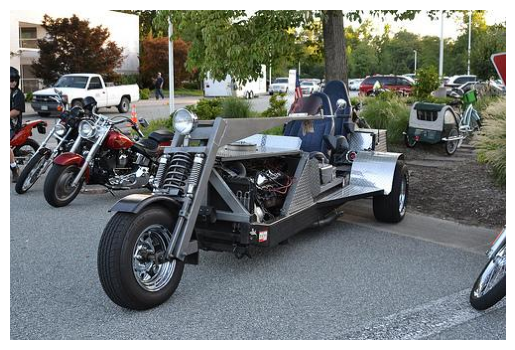

A sandwich is sitting on a white plate. The sandwich is cut in half and has lettuce, pickles, and a pickle on it. There is a side of fries on the plate.


In [23]:
show_image(f"{DATASET_BASE}/test/test_57.jpg")
generate_caption(f"{DATASET_BASE}/test/test_56.jpg")

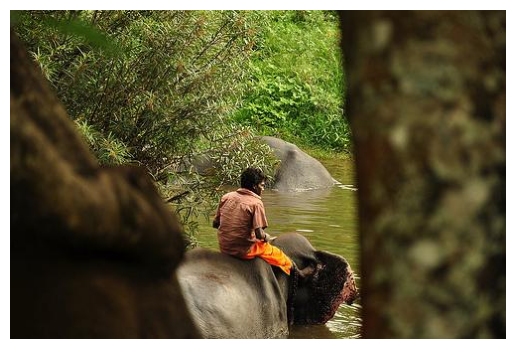

There is a man riding on the back of an elephant. The elephant has a mane on its back. The man is riding on top of the elephant. There is water behind the man on the water. There are trees on the side of the river.


In [24]:
show_image(f"{DATASET_BASE}/test/test_12.jpg")
generate_caption(f"{DATASET_BASE}/test/test_12.jpg")

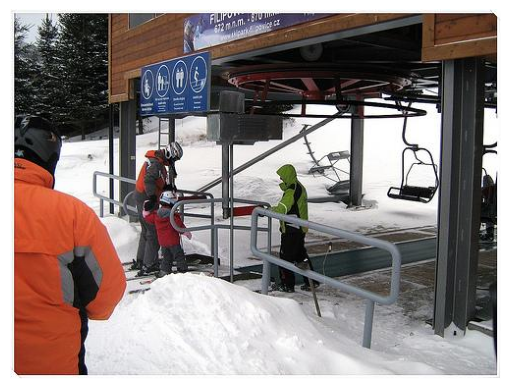

A man and woman are skiing down a snow covered mountain. The man is wearing skis and a helmet. The woman is wearing a ski jacket and a ski pants. Both of the people are wearing ski poles.


In [25]:
show_image(f"{DATASET_BASE}/test/test_37.jpg")
generate_caption(f"{DATASET_BASE}/test/test_37.jpg")

In [26]:
all_preds= []
all_labels = []
for index, row in df_test.iterrows():
    gen_kwargs = {"max_length": 239, "num_beams": 4}
    img_path = os.path.join(f'{DATASET_BASE}/test', row['filename'])
    img = Image.open(img_path).convert("RGB")
    pixel_values = feature_extractor(images=img, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(DEVICE_NAME)

    output_ids = model.generate(pixel_values, **gen_kwargs)

    preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    preds = [pred.strip() for pred in preds]
    preds = " ".join(preds)
    label = row['caption']
    all_labels.append(label)
    all_preds.append(preds)

In [27]:
rouge_output = rouge.compute(predictions=all_preds, references=all_labels, rouge_types=["rougeL"])["rougeL"].mid
print("Rouge_L score:",rouge_output)

Rouge_L score: Score(precision=0.3614999245327389, recall=0.2839090920931191, fmeasure=0.30195367117005245)
